# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

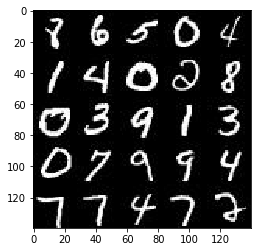

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

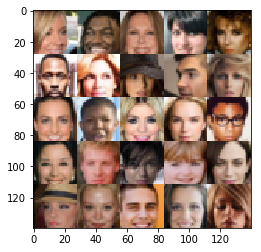

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/Ken/anaconda2/envs/deep2/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_images') 
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data') 
    learning_rate = tf.placeholder(tf.float32, name='learning_rate') 
    return (input_images, z_data, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.3
    
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
    
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
    
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    real_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    n_images = 25
    steps = 0
    print_interval = 10
    show_interval = 100
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: z_sample, lr: learning_rate})
                
                if steps % print_interval == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}\t".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}\t".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_interval == 0:
                    show_generator_output(sess, n_images, z_input, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2	 Discriminator Loss: 6.2911	 Generator Loss: 0.0062
Epoch 1/2	 Discriminator Loss: 0.1211	 Generator Loss: 7.9132
Epoch 1/2	 Discriminator Loss: 0.3743	 Generator Loss: 2.2915
Epoch 1/2	 Discriminator Loss: 0.0928	 Generator Loss: 5.0276
Epoch 1/2	 Discriminator Loss: 0.5373	 Generator Loss: 1.4094
Epoch 1/2	 Discriminator Loss: 0.5479	 Generator Loss: 1.2820
Epoch 1/2	 Discriminator Loss: 0.1957	 Generator Loss: 2.9332
Epoch 1/2	 Discriminator Loss: 2.8484	 Generator Loss: 0.1002
Epoch 1/2	 Discriminator Loss: 0.3767	 Generator Loss: 1.7485
Epoch 1/2	 Discriminator Loss: 2.6713	 Generator Loss: 14.2477


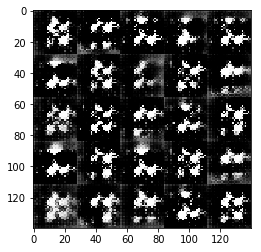

Epoch 1/2	 Discriminator Loss: 0.1826	 Generator Loss: 3.0718
Epoch 1/2	 Discriminator Loss: 0.6619	 Generator Loss: 4.7423
Epoch 1/2	 Discriminator Loss: 0.3889	 Generator Loss: 3.5057
Epoch 1/2	 Discriminator Loss: 1.0169	 Generator Loss: 6.3175
Epoch 1/2	 Discriminator Loss: 0.8694	 Generator Loss: 4.2067
Epoch 1/2	 Discriminator Loss: 0.8792	 Generator Loss: 5.9078
Epoch 1/2	 Discriminator Loss: 0.2684	 Generator Loss: 2.4073
Epoch 1/2	 Discriminator Loss: 3.2282	 Generator Loss: 0.2100
Epoch 1/2	 Discriminator Loss: 0.4518	 Generator Loss: 1.8298
Epoch 1/2	 Discriminator Loss: 0.4363	 Generator Loss: 2.6991


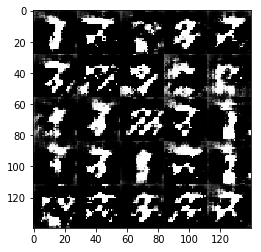

Epoch 1/2	 Discriminator Loss: 0.4329	 Generator Loss: 2.4691
Epoch 1/2	 Discriminator Loss: 0.2428	 Generator Loss: 3.9577
Epoch 1/2	 Discriminator Loss: 0.4504	 Generator Loss: 2.4462
Epoch 1/2	 Discriminator Loss: 0.4534	 Generator Loss: 2.2355
Epoch 1/2	 Discriminator Loss: 0.5409	 Generator Loss: 1.8587
Epoch 1/2	 Discriminator Loss: 0.2757	 Generator Loss: 2.7590
Epoch 1/2	 Discriminator Loss: 0.3895	 Generator Loss: 2.6583
Epoch 1/2	 Discriminator Loss: 0.3691	 Generator Loss: 5.0141
Epoch 1/2	 Discriminator Loss: 1.3013	 Generator Loss: 5.1232
Epoch 1/2	 Discriminator Loss: 0.3714	 Generator Loss: 2.4463


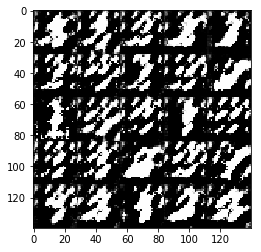

Epoch 1/2	 Discriminator Loss: 0.4826	 Generator Loss: 1.5185
Epoch 1/2	 Discriminator Loss: 0.2680	 Generator Loss: 2.6230
Epoch 1/2	 Discriminator Loss: 0.7116	 Generator Loss: 3.3361
Epoch 1/2	 Discriminator Loss: 0.5351	 Generator Loss: 1.9023
Epoch 1/2	 Discriminator Loss: 0.4521	 Generator Loss: 1.7408
Epoch 1/2	 Discriminator Loss: 1.0019	 Generator Loss: 2.3833
Epoch 1/2	 Discriminator Loss: 0.4365	 Generator Loss: 2.1679
Epoch 1/2	 Discriminator Loss: 0.3753	 Generator Loss: 3.7793
Epoch 1/2	 Discriminator Loss: 0.2834	 Generator Loss: 2.2530
Epoch 1/2	 Discriminator Loss: 1.2419	 Generator Loss: 0.9503


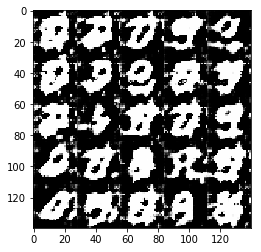

Epoch 1/2	 Discriminator Loss: 0.3417	 Generator Loss: 2.8489
Epoch 1/2	 Discriminator Loss: 1.1681	 Generator Loss: 4.7257
Epoch 1/2	 Discriminator Loss: 1.9327	 Generator Loss: 0.3559
Epoch 1/2	 Discriminator Loss: 0.7118	 Generator Loss: 1.3779
Epoch 1/2	 Discriminator Loss: 2.2457	 Generator Loss: 0.4048
Epoch 1/2	 Discriminator Loss: 0.4429	 Generator Loss: 2.1390
Epoch 1/2	 Discriminator Loss: 0.6200	 Generator Loss: 1.6080
Epoch 1/2	 Discriminator Loss: 0.3231	 Generator Loss: 2.0115
Epoch 1/2	 Discriminator Loss: 0.8590	 Generator Loss: 3.6898
Epoch 1/2	 Discriminator Loss: 0.6031	 Generator Loss: 2.4594


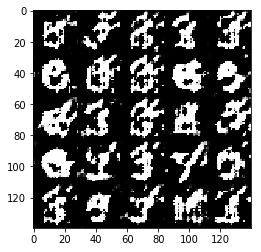

Epoch 1/2	 Discriminator Loss: 0.6207	 Generator Loss: 1.9922
Epoch 1/2	 Discriminator Loss: 0.6522	 Generator Loss: 2.7486
Epoch 1/2	 Discriminator Loss: 0.6891	 Generator Loss: 1.8636
Epoch 1/2	 Discriminator Loss: 0.5793	 Generator Loss: 1.3782
Epoch 1/2	 Discriminator Loss: 0.7443	 Generator Loss: 1.9603
Epoch 1/2	 Discriminator Loss: 0.6457	 Generator Loss: 1.7754
Epoch 1/2	 Discriminator Loss: 0.5691	 Generator Loss: 1.7412
Epoch 1/2	 Discriminator Loss: 0.7691	 Generator Loss: 1.0828
Epoch 1/2	 Discriminator Loss: 0.7564	 Generator Loss: 1.4263
Epoch 1/2	 Discriminator Loss: 0.5996	 Generator Loss: 1.3322


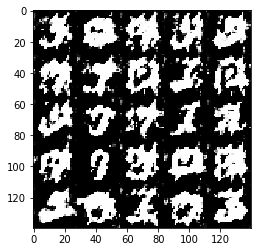

Epoch 1/2	 Discriminator Loss: 1.0920	 Generator Loss: 1.2091
Epoch 1/2	 Discriminator Loss: 0.4824	 Generator Loss: 3.2070
Epoch 1/2	 Discriminator Loss: 0.8666	 Generator Loss: 1.3251
Epoch 1/2	 Discriminator Loss: 0.5823	 Generator Loss: 1.4078
Epoch 1/2	 Discriminator Loss: 0.4768	 Generator Loss: 1.9714
Epoch 1/2	 Discriminator Loss: 0.5177	 Generator Loss: 2.1808
Epoch 1/2	 Discriminator Loss: 0.7125	 Generator Loss: 2.9000
Epoch 1/2	 Discriminator Loss: 0.4906	 Generator Loss: 1.7075
Epoch 1/2	 Discriminator Loss: 0.5377	 Generator Loss: 2.1059
Epoch 1/2	 Discriminator Loss: 0.6249	 Generator Loss: 1.4497


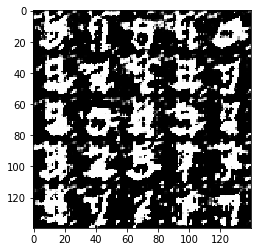

Epoch 1/2	 Discriminator Loss: 0.6706	 Generator Loss: 1.5502
Epoch 1/2	 Discriminator Loss: 0.4190	 Generator Loss: 2.8893
Epoch 1/2	 Discriminator Loss: 0.7611	 Generator Loss: 1.6959
Epoch 1/2	 Discriminator Loss: 0.4669	 Generator Loss: 1.6477
Epoch 1/2	 Discriminator Loss: 0.4584	 Generator Loss: 1.8923
Epoch 1/2	 Discriminator Loss: 0.6718	 Generator Loss: 1.5988
Epoch 1/2	 Discriminator Loss: 0.9975	 Generator Loss: 1.2051
Epoch 1/2	 Discriminator Loss: 0.9387	 Generator Loss: 2.5187
Epoch 1/2	 Discriminator Loss: 1.2744	 Generator Loss: 0.6704
Epoch 1/2	 Discriminator Loss: 0.5895	 Generator Loss: 1.4200


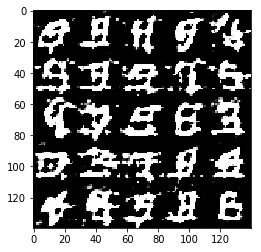

Epoch 1/2	 Discriminator Loss: 0.7370	 Generator Loss: 1.3943
Epoch 1/2	 Discriminator Loss: 0.4883	 Generator Loss: 2.4206
Epoch 1/2	 Discriminator Loss: 0.6894	 Generator Loss: 1.2458
Epoch 1/2	 Discriminator Loss: 0.4273	 Generator Loss: 3.0037
Epoch 1/2	 Discriminator Loss: 0.8002	 Generator Loss: 3.3656
Epoch 1/2	 Discriminator Loss: 0.6638	 Generator Loss: 1.4242
Epoch 1/2	 Discriminator Loss: 0.8374	 Generator Loss: 1.1250
Epoch 1/2	 Discriminator Loss: 0.9037	 Generator Loss: 1.1440
Epoch 1/2	 Discriminator Loss: 0.5272	 Generator Loss: 1.9183
Epoch 1/2	 Discriminator Loss: 0.6203	 Generator Loss: 3.3984


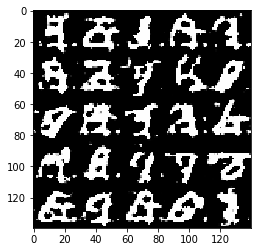

Epoch 1/2	 Discriminator Loss: 0.6270	 Generator Loss: 1.8513
Epoch 1/2	 Discriminator Loss: 0.4505	 Generator Loss: 2.7662
Epoch 1/2	 Discriminator Loss: 0.8023	 Generator Loss: 3.4109
Epoch 2/2	 Discriminator Loss: 0.6369	 Generator Loss: 1.6209
Epoch 2/2	 Discriminator Loss: 0.7055	 Generator Loss: 1.2396
Epoch 2/2	 Discriminator Loss: 0.7241	 Generator Loss: 1.4941
Epoch 2/2	 Discriminator Loss: 0.4972	 Generator Loss: 2.0388
Epoch 2/2	 Discriminator Loss: 0.8328	 Generator Loss: 3.1667
Epoch 2/2	 Discriminator Loss: 0.9131	 Generator Loss: 1.0089
Epoch 2/2	 Discriminator Loss: 0.9509	 Generator Loss: 1.0381


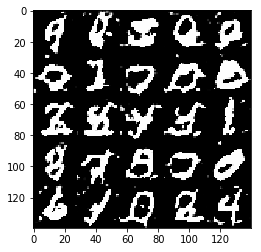

Epoch 2/2	 Discriminator Loss: 0.7414	 Generator Loss: 1.2974
Epoch 2/2	 Discriminator Loss: 0.7960	 Generator Loss: 2.8833
Epoch 2/2	 Discriminator Loss: 0.9844	 Generator Loss: 0.7316
Epoch 2/2	 Discriminator Loss: 0.7190	 Generator Loss: 1.6363
Epoch 2/2	 Discriminator Loss: 0.4332	 Generator Loss: 1.9909
Epoch 2/2	 Discriminator Loss: 0.7981	 Generator Loss: 1.4975
Epoch 2/2	 Discriminator Loss: 0.5258	 Generator Loss: 1.7882
Epoch 2/2	 Discriminator Loss: 0.5122	 Generator Loss: 1.9286
Epoch 2/2	 Discriminator Loss: 0.7882	 Generator Loss: 2.5367
Epoch 2/2	 Discriminator Loss: 0.5741	 Generator Loss: 2.7009


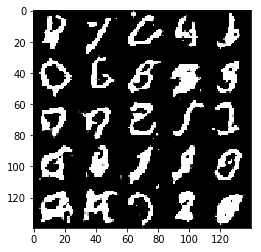

Epoch 2/2	 Discriminator Loss: 0.7901	 Generator Loss: 1.0845
Epoch 2/2	 Discriminator Loss: 0.5694	 Generator Loss: 1.7145
Epoch 2/2	 Discriminator Loss: 0.3860	 Generator Loss: 3.0577
Epoch 2/2	 Discriminator Loss: 0.8360	 Generator Loss: 1.0194
Epoch 2/2	 Discriminator Loss: 0.6499	 Generator Loss: 1.8407
Epoch 2/2	 Discriminator Loss: 0.6696	 Generator Loss: 1.2108
Epoch 2/2	 Discriminator Loss: 0.5232	 Generator Loss: 1.4125
Epoch 2/2	 Discriminator Loss: 0.5170	 Generator Loss: 1.5453
Epoch 2/2	 Discriminator Loss: 0.5657	 Generator Loss: 1.8629
Epoch 2/2	 Discriminator Loss: 1.0648	 Generator Loss: 3.5430


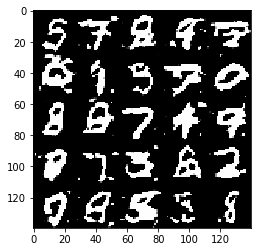

Epoch 2/2	 Discriminator Loss: 1.0512	 Generator Loss: 0.7194
Epoch 2/2	 Discriminator Loss: 0.9087	 Generator Loss: 1.0020
Epoch 2/2	 Discriminator Loss: 0.7037	 Generator Loss: 1.1339
Epoch 2/2	 Discriminator Loss: 0.6042	 Generator Loss: 1.3005
Epoch 2/2	 Discriminator Loss: 1.6153	 Generator Loss: 3.3734
Epoch 2/2	 Discriminator Loss: 0.9259	 Generator Loss: 0.9627
Epoch 2/2	 Discriminator Loss: 0.5543	 Generator Loss: 1.5592
Epoch 2/2	 Discriminator Loss: 1.3801	 Generator Loss: 0.5364
Epoch 2/2	 Discriminator Loss: 0.5267	 Generator Loss: 2.3675
Epoch 2/2	 Discriminator Loss: 1.4029	 Generator Loss: 0.7096


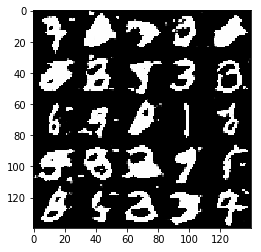

Epoch 2/2	 Discriminator Loss: 1.3341	 Generator Loss: 0.5861
Epoch 2/2	 Discriminator Loss: 0.6069	 Generator Loss: 1.4485
Epoch 2/2	 Discriminator Loss: 0.6039	 Generator Loss: 1.5133
Epoch 2/2	 Discriminator Loss: 1.6704	 Generator Loss: 0.3689
Epoch 2/2	 Discriminator Loss: 0.9380	 Generator Loss: 0.8390
Epoch 2/2	 Discriminator Loss: 0.5824	 Generator Loss: 2.5498
Epoch 2/2	 Discriminator Loss: 0.8619	 Generator Loss: 0.9425
Epoch 2/2	 Discriminator Loss: 0.6658	 Generator Loss: 1.4110
Epoch 2/2	 Discriminator Loss: 0.5709	 Generator Loss: 1.5325
Epoch 2/2	 Discriminator Loss: 0.7527	 Generator Loss: 0.9612


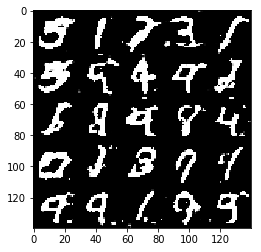

Epoch 2/2	 Discriminator Loss: 2.8847	 Generator Loss: 0.1488
Epoch 2/2	 Discriminator Loss: 0.7009	 Generator Loss: 1.2429
Epoch 2/2	 Discriminator Loss: 0.7530	 Generator Loss: 3.2352
Epoch 2/2	 Discriminator Loss: 0.7365	 Generator Loss: 1.0566
Epoch 2/2	 Discriminator Loss: 0.6278	 Generator Loss: 1.2924
Epoch 2/2	 Discriminator Loss: 0.3785	 Generator Loss: 1.9677
Epoch 2/2	 Discriminator Loss: 0.3975	 Generator Loss: 1.8776
Epoch 2/2	 Discriminator Loss: 0.4843	 Generator Loss: 1.3508
Epoch 2/2	 Discriminator Loss: 0.5305	 Generator Loss: 1.1688
Epoch 2/2	 Discriminator Loss: 0.4635	 Generator Loss: 1.7867


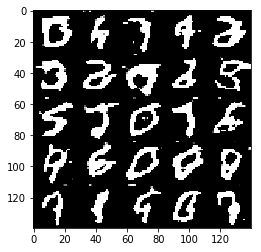

Epoch 2/2	 Discriminator Loss: 5.0959	 Generator Loss: 0.0312
Epoch 2/2	 Discriminator Loss: 1.0085	 Generator Loss: 0.8982
Epoch 2/2	 Discriminator Loss: 0.6912	 Generator Loss: 2.0947
Epoch 2/2	 Discriminator Loss: 1.1274	 Generator Loss: 0.6452
Epoch 2/2	 Discriminator Loss: 1.3962	 Generator Loss: 0.6375
Epoch 2/2	 Discriminator Loss: 0.4601	 Generator Loss: 1.7728
Epoch 2/2	 Discriminator Loss: 0.8095	 Generator Loss: 0.9970
Epoch 2/2	 Discriminator Loss: 0.6957	 Generator Loss: 1.0263
Epoch 2/2	 Discriminator Loss: 0.4764	 Generator Loss: 2.3319
Epoch 2/2	 Discriminator Loss: 0.2952	 Generator Loss: 2.1911


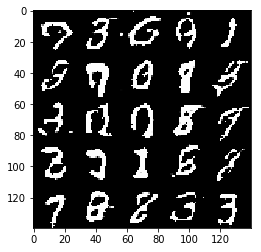

Epoch 2/2	 Discriminator Loss: 0.6234	 Generator Loss: 3.2196
Epoch 2/2	 Discriminator Loss: 0.6030	 Generator Loss: 2.2494
Epoch 2/2	 Discriminator Loss: 0.2377	 Generator Loss: 2.9808
Epoch 2/2	 Discriminator Loss: 0.9791	 Generator Loss: 0.8332
Epoch 2/2	 Discriminator Loss: 0.4582	 Generator Loss: 1.9184
Epoch 2/2	 Discriminator Loss: 1.8628	 Generator Loss: 0.2680
Epoch 2/2	 Discriminator Loss: 1.2036	 Generator Loss: 0.6075
Epoch 2/2	 Discriminator Loss: 0.5768	 Generator Loss: 1.1928
Epoch 2/2	 Discriminator Loss: 0.6118	 Generator Loss: 1.1495
Epoch 2/2	 Discriminator Loss: 0.5293	 Generator Loss: 1.6636


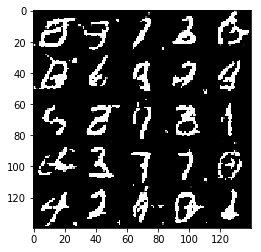

Epoch 2/2	 Discriminator Loss: 0.4895	 Generator Loss: 1.4571
Epoch 2/2	 Discriminator Loss: 0.6003	 Generator Loss: 1.1209
Epoch 2/2	 Discriminator Loss: 1.2990	 Generator Loss: 0.6516
Epoch 2/2	 Discriminator Loss: 0.9396	 Generator Loss: 1.6958
Epoch 2/2	 Discriminator Loss: 1.0539	 Generator Loss: 1.4011
Epoch 2/2	 Discriminator Loss: 1.2930	 Generator Loss: 0.5756
Epoch 2/2	 Discriminator Loss: 0.8422	 Generator Loss: 0.9918
Epoch 2/2	 Discriminator Loss: 0.7812	 Generator Loss: 2.6888
Epoch 2/2	 Discriminator Loss: 0.7189	 Generator Loss: 1.2016
Epoch 2/2	 Discriminator Loss: 1.6633	 Generator Loss: 0.3833


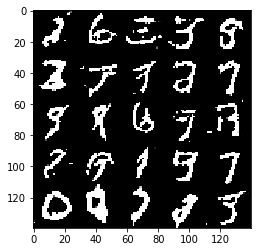

Epoch 2/2	 Discriminator Loss: 0.6304	 Generator Loss: 1.2478
Epoch 2/2	 Discriminator Loss: 0.7784	 Generator Loss: 0.9018
Epoch 2/2	 Discriminator Loss: 0.3826	 Generator Loss: 1.4826
Epoch 2/2	 Discriminator Loss: 0.3760	 Generator Loss: 2.4769
Epoch 2/2	 Discriminator Loss: 1.2778	 Generator Loss: 0.5370
Epoch 2/2	 Discriminator Loss: 0.8308	 Generator Loss: 0.9588
Epoch 2/2	 Discriminator Loss: 2.4046	 Generator Loss: 6.2203


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1	 Discriminator Loss: 0.2212	 Generator Loss: 11.7698
Epoch 1/1	 Discriminator Loss: 0.5480	 Generator Loss: 6.9410
Epoch 1/1	 Discriminator Loss: 0.0165	 Generator Loss: 7.0665
Epoch 1/1	 Discriminator Loss: 0.1605	 Generator Loss: 14.7317
Epoch 1/1	 Discriminator Loss: 0.5907	 Generator Loss: 1.4533
Epoch 1/1	 Discriminator Loss: 1.0710	 Generator Loss: 4.3103
Epoch 1/1	 Discriminator Loss: 3.2318	 Generator Loss: 0.1578
Epoch 1/1	 Discriminator Loss: 0.7674	 Generator Loss: 2.0647
Epoch 1/1	 Discriminator Loss: 1.3801	 Generator Loss: 0.7501
Epoch 1/1	 Discriminator Loss: 2.3029	 Generator Loss: 7.9415


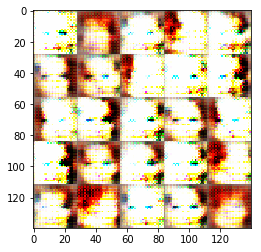

Epoch 1/1	 Discriminator Loss: 0.3871	 Generator Loss: 2.0574
Epoch 1/1	 Discriminator Loss: 0.1593	 Generator Loss: 2.6008
Epoch 1/1	 Discriminator Loss: 0.0694	 Generator Loss: 3.7627
Epoch 1/1	 Discriminator Loss: 0.6681	 Generator Loss: 1.1186
Epoch 1/1	 Discriminator Loss: 0.1492	 Generator Loss: 7.7433
Epoch 1/1	 Discriminator Loss: 0.0751	 Generator Loss: 4.0563
Epoch 1/1	 Discriminator Loss: 0.2485	 Generator Loss: 2.3207
Epoch 1/1	 Discriminator Loss: 3.3303	 Generator Loss: 7.5362
Epoch 1/1	 Discriminator Loss: 0.4442	 Generator Loss: 1.3030
Epoch 1/1	 Discriminator Loss: 0.1482	 Generator Loss: 2.8825


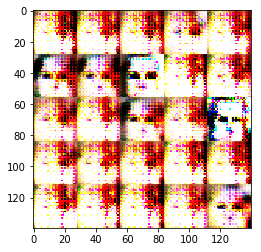

Epoch 1/1	 Discriminator Loss: 0.0860	 Generator Loss: 3.6089
Epoch 1/1	 Discriminator Loss: 0.4523	 Generator Loss: 1.6878
Epoch 1/1	 Discriminator Loss: 0.3041	 Generator Loss: 2.1127
Epoch 1/1	 Discriminator Loss: 0.6303	 Generator Loss: 1.9264
Epoch 1/1	 Discriminator Loss: 0.5357	 Generator Loss: 3.3764
Epoch 1/1	 Discriminator Loss: 0.7335	 Generator Loss: 2.1322
Epoch 1/1	 Discriminator Loss: 0.5317	 Generator Loss: 2.7297
Epoch 1/1	 Discriminator Loss: 0.4313	 Generator Loss: 2.1986
Epoch 1/1	 Discriminator Loss: 1.3923	 Generator Loss: 2.7171
Epoch 1/1	 Discriminator Loss: 0.6952	 Generator Loss: 1.3671


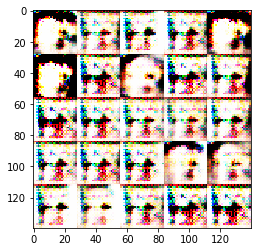

Epoch 1/1	 Discriminator Loss: 0.4518	 Generator Loss: 2.2544
Epoch 1/1	 Discriminator Loss: 1.0306	 Generator Loss: 1.4274
Epoch 1/1	 Discriminator Loss: 0.6369	 Generator Loss: 1.8730
Epoch 1/1	 Discriminator Loss: 1.0920	 Generator Loss: 0.7221
Epoch 1/1	 Discriminator Loss: 0.7829	 Generator Loss: 1.0919
Epoch 1/1	 Discriminator Loss: 5.3297	 Generator Loss: 5.4341
Epoch 1/1	 Discriminator Loss: 1.2313	 Generator Loss: 0.8503
Epoch 1/1	 Discriminator Loss: 1.3234	 Generator Loss: 0.7984
Epoch 1/1	 Discriminator Loss: 1.5794	 Generator Loss: 0.8064
Epoch 1/1	 Discriminator Loss: 0.8217	 Generator Loss: 1.2169


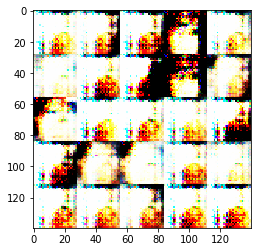

Epoch 1/1	 Discriminator Loss: 0.6190	 Generator Loss: 1.4790
Epoch 1/1	 Discriminator Loss: 1.3193	 Generator Loss: 3.5190
Epoch 1/1	 Discriminator Loss: 1.5463	 Generator Loss: 3.5751
Epoch 1/1	 Discriminator Loss: 0.6084	 Generator Loss: 2.1401
Epoch 1/1	 Discriminator Loss: 0.8572	 Generator Loss: 1.0367
Epoch 1/1	 Discriminator Loss: 1.0412	 Generator Loss: 0.9371
Epoch 1/1	 Discriminator Loss: 0.9305	 Generator Loss: 1.1962
Epoch 1/1	 Discriminator Loss: 1.5677	 Generator Loss: 2.7018
Epoch 1/1	 Discriminator Loss: 0.5609	 Generator Loss: 1.2121
Epoch 1/1	 Discriminator Loss: 0.6999	 Generator Loss: 2.2761


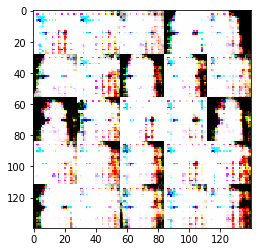

Epoch 1/1	 Discriminator Loss: 0.6638	 Generator Loss: 1.0649
Epoch 1/1	 Discriminator Loss: 1.8190	 Generator Loss: 0.2946
Epoch 1/1	 Discriminator Loss: 1.5969	 Generator Loss: 1.9016
Epoch 1/1	 Discriminator Loss: 3.5656	 Generator Loss: 4.9230
Epoch 1/1	 Discriminator Loss: 0.7620	 Generator Loss: 1.3384
Epoch 1/1	 Discriminator Loss: 1.0045	 Generator Loss: 1.2177
Epoch 1/1	 Discriminator Loss: 1.1738	 Generator Loss: 0.9725
Epoch 1/1	 Discriminator Loss: 1.5674	 Generator Loss: 0.4517
Epoch 1/1	 Discriminator Loss: 1.3381	 Generator Loss: 0.5087
Epoch 1/1	 Discriminator Loss: 0.9669	 Generator Loss: 0.9376


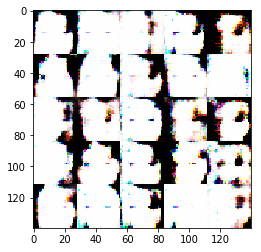

Epoch 1/1	 Discriminator Loss: 1.9610	 Generator Loss: 2.9455
Epoch 1/1	 Discriminator Loss: 1.6864	 Generator Loss: 0.3309
Epoch 1/1	 Discriminator Loss: 1.0710	 Generator Loss: 0.8196
Epoch 1/1	 Discriminator Loss: 0.8212	 Generator Loss: 0.8856
Epoch 1/1	 Discriminator Loss: 1.1218	 Generator Loss: 0.6737
Epoch 1/1	 Discriminator Loss: 1.3012	 Generator Loss: 2.2558
Epoch 1/1	 Discriminator Loss: 1.0827	 Generator Loss: 0.9234
Epoch 1/1	 Discriminator Loss: 0.6817	 Generator Loss: 1.2995
Epoch 1/1	 Discriminator Loss: 1.1738	 Generator Loss: 1.8928
Epoch 1/1	 Discriminator Loss: 1.8409	 Generator Loss: 3.0672


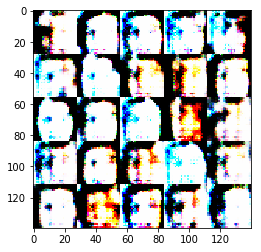

Epoch 1/1	 Discriminator Loss: 0.7129	 Generator Loss: 1.1153
Epoch 1/1	 Discriminator Loss: 1.0178	 Generator Loss: 0.8928
Epoch 1/1	 Discriminator Loss: 1.4504	 Generator Loss: 0.5496
Epoch 1/1	 Discriminator Loss: 0.8204	 Generator Loss: 1.2277
Epoch 1/1	 Discriminator Loss: 0.9761	 Generator Loss: 0.9873
Epoch 1/1	 Discriminator Loss: 1.3374	 Generator Loss: 0.4790
Epoch 1/1	 Discriminator Loss: 0.6341	 Generator Loss: 1.7244
Epoch 1/1	 Discriminator Loss: 1.6080	 Generator Loss: 0.3743
Epoch 1/1	 Discriminator Loss: 0.9336	 Generator Loss: 1.1842
Epoch 1/1	 Discriminator Loss: 0.8607	 Generator Loss: 1.6030


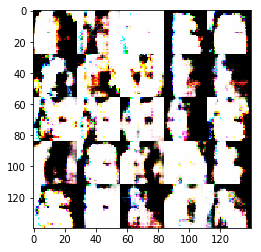

Epoch 1/1	 Discriminator Loss: 1.1053	 Generator Loss: 1.7430
Epoch 1/1	 Discriminator Loss: 1.2294	 Generator Loss: 0.5523
Epoch 1/1	 Discriminator Loss: 1.0530	 Generator Loss: 1.4063
Epoch 1/1	 Discriminator Loss: 0.8414	 Generator Loss: 1.5452
Epoch 1/1	 Discriminator Loss: 0.9020	 Generator Loss: 2.3696
Epoch 1/1	 Discriminator Loss: 1.0185	 Generator Loss: 2.2413
Epoch 1/1	 Discriminator Loss: 1.1982	 Generator Loss: 0.5059
Epoch 1/1	 Discriminator Loss: 0.8577	 Generator Loss: 1.6978
Epoch 1/1	 Discriminator Loss: 1.0255	 Generator Loss: 1.3685
Epoch 1/1	 Discriminator Loss: 1.2290	 Generator Loss: 2.6401


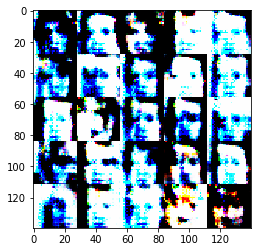

Epoch 1/1	 Discriminator Loss: 1.2903	 Generator Loss: 0.5941
Epoch 1/1	 Discriminator Loss: 0.9186	 Generator Loss: 1.1039
Epoch 1/1	 Discriminator Loss: 1.1645	 Generator Loss: 1.5219
Epoch 1/1	 Discriminator Loss: 0.8992	 Generator Loss: 1.1914
Epoch 1/1	 Discriminator Loss: 2.0868	 Generator Loss: 3.2832
Epoch 1/1	 Discriminator Loss: 1.1205	 Generator Loss: 1.2031
Epoch 1/1	 Discriminator Loss: 1.4056	 Generator Loss: 2.1603
Epoch 1/1	 Discriminator Loss: 2.1147	 Generator Loss: 4.3306
Epoch 1/1	 Discriminator Loss: 1.0073	 Generator Loss: 0.7709
Epoch 1/1	 Discriminator Loss: 1.1327	 Generator Loss: 1.8048


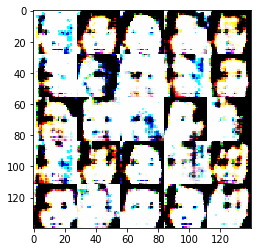

Epoch 1/1	 Discriminator Loss: 1.3594	 Generator Loss: 3.2073
Epoch 1/1	 Discriminator Loss: 0.7527	 Generator Loss: 1.2549
Epoch 1/1	 Discriminator Loss: 1.2103	 Generator Loss: 0.8939
Epoch 1/1	 Discriminator Loss: 0.9900	 Generator Loss: 1.2203
Epoch 1/1	 Discriminator Loss: 1.0262	 Generator Loss: 2.7171
Epoch 1/1	 Discriminator Loss: 0.9346	 Generator Loss: 0.7227
Epoch 1/1	 Discriminator Loss: 0.8361	 Generator Loss: 0.9864
Epoch 1/1	 Discriminator Loss: 0.9722	 Generator Loss: 0.7729
Epoch 1/1	 Discriminator Loss: 1.6914	 Generator Loss: 0.4180
Epoch 1/1	 Discriminator Loss: 0.7823	 Generator Loss: 1.7487


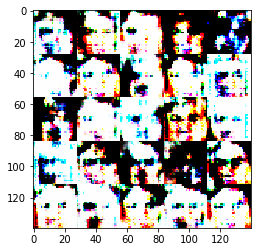

Epoch 1/1	 Discriminator Loss: 0.7531	 Generator Loss: 0.9460
Epoch 1/1	 Discriminator Loss: 1.1053	 Generator Loss: 2.2356
Epoch 1/1	 Discriminator Loss: 1.6096	 Generator Loss: 0.3531
Epoch 1/1	 Discriminator Loss: 1.2418	 Generator Loss: 0.6082
Epoch 1/1	 Discriminator Loss: 0.9253	 Generator Loss: 0.7872
Epoch 1/1	 Discriminator Loss: 1.0355	 Generator Loss: 1.3486
Epoch 1/1	 Discriminator Loss: 0.9786	 Generator Loss: 1.1005
Epoch 1/1	 Discriminator Loss: 1.7472	 Generator Loss: 0.3334
Epoch 1/1	 Discriminator Loss: 1.6317	 Generator Loss: 0.4260
Epoch 1/1	 Discriminator Loss: 0.8829	 Generator Loss: 1.5868


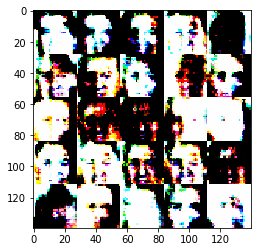

Epoch 1/1	 Discriminator Loss: 1.0577	 Generator Loss: 2.5040
Epoch 1/1	 Discriminator Loss: 1.1047	 Generator Loss: 1.1972
Epoch 1/1	 Discriminator Loss: 1.0957	 Generator Loss: 0.7125
Epoch 1/1	 Discriminator Loss: 2.6662	 Generator Loss: 4.1608
Epoch 1/1	 Discriminator Loss: 1.2083	 Generator Loss: 0.8077
Epoch 1/1	 Discriminator Loss: 0.7934	 Generator Loss: 1.7392
Epoch 1/1	 Discriminator Loss: 1.0173	 Generator Loss: 1.1150
Epoch 1/1	 Discriminator Loss: 0.9983	 Generator Loss: 1.0026
Epoch 1/1	 Discriminator Loss: 1.0031	 Generator Loss: 2.0667
Epoch 1/1	 Discriminator Loss: 0.8206	 Generator Loss: 1.0166


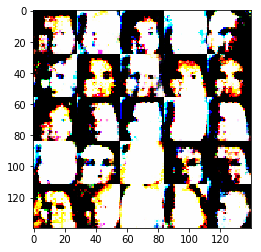

Epoch 1/1	 Discriminator Loss: 1.2821	 Generator Loss: 0.9266
Epoch 1/1	 Discriminator Loss: 1.3619	 Generator Loss: 0.6481
Epoch 1/1	 Discriminator Loss: 0.8494	 Generator Loss: 0.9343
Epoch 1/1	 Discriminator Loss: 0.7651	 Generator Loss: 2.1002
Epoch 1/1	 Discriminator Loss: 0.8494	 Generator Loss: 1.8730
Epoch 1/1	 Discriminator Loss: 1.4727	 Generator Loss: 0.7227
Epoch 1/1	 Discriminator Loss: 0.9252	 Generator Loss: 1.4615
Epoch 1/1	 Discriminator Loss: 1.1131	 Generator Loss: 1.4899
Epoch 1/1	 Discriminator Loss: 0.8127	 Generator Loss: 1.1314
Epoch 1/1	 Discriminator Loss: 0.8019	 Generator Loss: 1.6365


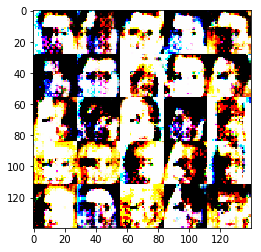

Epoch 1/1	 Discriminator Loss: 0.9394	 Generator Loss: 2.0143
Epoch 1/1	 Discriminator Loss: 1.2739	 Generator Loss: 0.7002
Epoch 1/1	 Discriminator Loss: 0.8847	 Generator Loss: 1.4898
Epoch 1/1	 Discriminator Loss: 0.8869	 Generator Loss: 1.0615
Epoch 1/1	 Discriminator Loss: 1.2375	 Generator Loss: 0.6028
Epoch 1/1	 Discriminator Loss: 0.8943	 Generator Loss: 0.8615
Epoch 1/1	 Discriminator Loss: 1.0202	 Generator Loss: 0.9110
Epoch 1/1	 Discriminator Loss: 1.0586	 Generator Loss: 0.7459
Epoch 1/1	 Discriminator Loss: 1.2621	 Generator Loss: 1.5314
Epoch 1/1	 Discriminator Loss: 1.2949	 Generator Loss: 0.5688


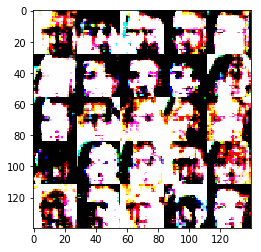

Epoch 1/1	 Discriminator Loss: 1.1658	 Generator Loss: 0.6190
Epoch 1/1	 Discriminator Loss: 0.6952	 Generator Loss: 1.5442
Epoch 1/1	 Discriminator Loss: 0.8722	 Generator Loss: 1.4222
Epoch 1/1	 Discriminator Loss: 0.8893	 Generator Loss: 1.3710
Epoch 1/1	 Discriminator Loss: 1.1039	 Generator Loss: 0.6204
Epoch 1/1	 Discriminator Loss: 0.9511	 Generator Loss: 1.0349
Epoch 1/1	 Discriminator Loss: 0.8144	 Generator Loss: 1.3290
Epoch 1/1	 Discriminator Loss: 1.3661	 Generator Loss: 0.8366
Epoch 1/1	 Discriminator Loss: 1.1957	 Generator Loss: 0.8608
Epoch 1/1	 Discriminator Loss: 0.6358	 Generator Loss: 2.0245


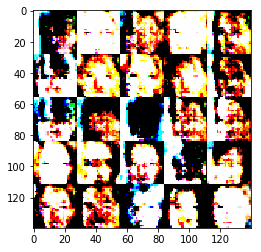

Epoch 1/1	 Discriminator Loss: 1.1754	 Generator Loss: 2.7526
Epoch 1/1	 Discriminator Loss: 0.7415	 Generator Loss: 1.7552
Epoch 1/1	 Discriminator Loss: 0.6427	 Generator Loss: 1.6192
Epoch 1/1	 Discriminator Loss: 1.0257	 Generator Loss: 1.1578
Epoch 1/1	 Discriminator Loss: 0.7709	 Generator Loss: 1.3791
Epoch 1/1	 Discriminator Loss: 1.3798	 Generator Loss: 2.1969
Epoch 1/1	 Discriminator Loss: 1.1369	 Generator Loss: 0.5917
Epoch 1/1	 Discriminator Loss: 1.5054	 Generator Loss: 1.8413
Epoch 1/1	 Discriminator Loss: 0.8612	 Generator Loss: 1.2127
Epoch 1/1	 Discriminator Loss: 0.9294	 Generator Loss: 0.9440


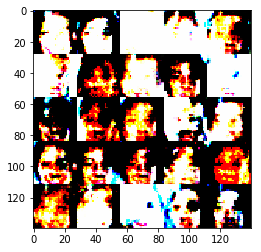

Epoch 1/1	 Discriminator Loss: 0.7819	 Generator Loss: 1.3766
Epoch 1/1	 Discriminator Loss: 0.9862	 Generator Loss: 0.8758
Epoch 1/1	 Discriminator Loss: 0.8002	 Generator Loss: 1.5317
Epoch 1/1	 Discriminator Loss: 0.7776	 Generator Loss: 1.3309
Epoch 1/1	 Discriminator Loss: 0.9094	 Generator Loss: 1.7151
Epoch 1/1	 Discriminator Loss: 1.3930	 Generator Loss: 2.6875
Epoch 1/1	 Discriminator Loss: 1.5513	 Generator Loss: 0.5238
Epoch 1/1	 Discriminator Loss: 1.2882	 Generator Loss: 1.7672
Epoch 1/1	 Discriminator Loss: 1.0228	 Generator Loss: 1.3911
Epoch 1/1	 Discriminator Loss: 0.9358	 Generator Loss: 1.2210


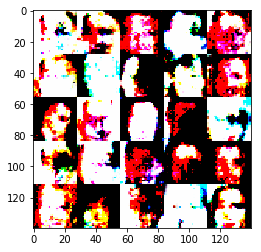

Epoch 1/1	 Discriminator Loss: 0.6291	 Generator Loss: 1.8359
Epoch 1/1	 Discriminator Loss: 0.9873	 Generator Loss: 0.9248
Epoch 1/1	 Discriminator Loss: 0.6679	 Generator Loss: 1.7222
Epoch 1/1	 Discriminator Loss: 0.9224	 Generator Loss: 0.8845
Epoch 1/1	 Discriminator Loss: 1.0732	 Generator Loss: 0.7335
Epoch 1/1	 Discriminator Loss: 0.8764	 Generator Loss: 1.5153
Epoch 1/1	 Discriminator Loss: 0.9926	 Generator Loss: 1.7968
Epoch 1/1	 Discriminator Loss: 1.3514	 Generator Loss: 0.5810
Epoch 1/1	 Discriminator Loss: 0.9364	 Generator Loss: 0.9948
Epoch 1/1	 Discriminator Loss: 0.9376	 Generator Loss: 0.9374


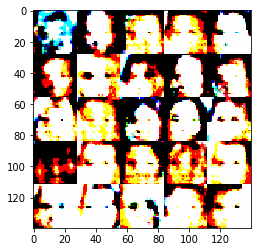

Epoch 1/1	 Discriminator Loss: 1.1658	 Generator Loss: 0.6896
Epoch 1/1	 Discriminator Loss: 0.7475	 Generator Loss: 2.0020
Epoch 1/1	 Discriminator Loss: 0.8684	 Generator Loss: 0.9048
Epoch 1/1	 Discriminator Loss: 0.6676	 Generator Loss: 2.3978
Epoch 1/1	 Discriminator Loss: 0.6644	 Generator Loss: 2.2044
Epoch 1/1	 Discriminator Loss: 0.8622	 Generator Loss: 1.7203
Epoch 1/1	 Discriminator Loss: 0.9155	 Generator Loss: 0.9130
Epoch 1/1	 Discriminator Loss: 1.4304	 Generator Loss: 0.7170
Epoch 1/1	 Discriminator Loss: 0.8041	 Generator Loss: 1.6753
Epoch 1/1	 Discriminator Loss: 1.7491	 Generator Loss: 0.2841


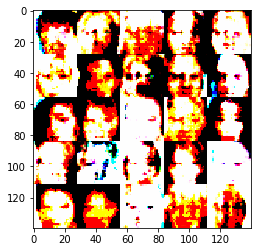

Epoch 1/1	 Discriminator Loss: 1.2444	 Generator Loss: 2.2482
Epoch 1/1	 Discriminator Loss: 0.7318	 Generator Loss: 1.0947
Epoch 1/1	 Discriminator Loss: 0.9102	 Generator Loss: 1.2104
Epoch 1/1	 Discriminator Loss: 0.8635	 Generator Loss: 1.3082
Epoch 1/1	 Discriminator Loss: 1.0787	 Generator Loss: 0.8621
Epoch 1/1	 Discriminator Loss: 0.8739	 Generator Loss: 1.2339
Epoch 1/1	 Discriminator Loss: 0.7403	 Generator Loss: 1.4174
Epoch 1/1	 Discriminator Loss: 0.4853	 Generator Loss: 1.8547
Epoch 1/1	 Discriminator Loss: 0.6844	 Generator Loss: 1.6955
Epoch 1/1	 Discriminator Loss: 1.5206	 Generator Loss: 0.3779


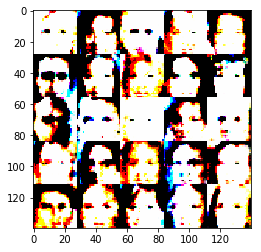

Epoch 1/1	 Discriminator Loss: 1.1668	 Generator Loss: 1.9698
Epoch 1/1	 Discriminator Loss: 0.6276	 Generator Loss: 2.1250
Epoch 1/1	 Discriminator Loss: 1.0193	 Generator Loss: 0.7261
Epoch 1/1	 Discriminator Loss: 1.0432	 Generator Loss: 0.7205
Epoch 1/1	 Discriminator Loss: 0.7824	 Generator Loss: 1.0449
Epoch 1/1	 Discriminator Loss: 1.1947	 Generator Loss: 1.2619
Epoch 1/1	 Discriminator Loss: 0.9000	 Generator Loss: 1.6071
Epoch 1/1	 Discriminator Loss: 1.4660	 Generator Loss: 0.4390
Epoch 1/1	 Discriminator Loss: 0.9533	 Generator Loss: 1.4759
Epoch 1/1	 Discriminator Loss: 2.3401	 Generator Loss: 3.4282


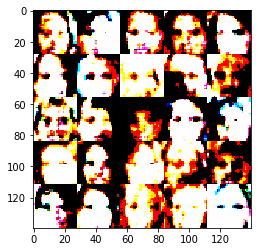

Epoch 1/1	 Discriminator Loss: 0.9571	 Generator Loss: 1.3512
Epoch 1/1	 Discriminator Loss: 1.0797	 Generator Loss: 0.8886
Epoch 1/1	 Discriminator Loss: 1.2628	 Generator Loss: 0.5513
Epoch 1/1	 Discriminator Loss: 1.2131	 Generator Loss: 0.9741
Epoch 1/1	 Discriminator Loss: 1.4330	 Generator Loss: 0.4899
Epoch 1/1	 Discriminator Loss: 1.2035	 Generator Loss: 0.6022
Epoch 1/1	 Discriminator Loss: 1.2262	 Generator Loss: 2.4413
Epoch 1/1	 Discriminator Loss: 1.0227	 Generator Loss: 1.9885
Epoch 1/1	 Discriminator Loss: 0.7217	 Generator Loss: 1.9907
Epoch 1/1	 Discriminator Loss: 1.1605	 Generator Loss: 0.6943


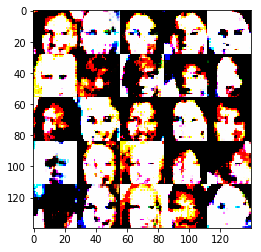

Epoch 1/1	 Discriminator Loss: 0.9601	 Generator Loss: 0.9405
Epoch 1/1	 Discriminator Loss: 1.6528	 Generator Loss: 2.7199
Epoch 1/1	 Discriminator Loss: 0.7633	 Generator Loss: 1.7373
Epoch 1/1	 Discriminator Loss: 1.5658	 Generator Loss: 0.5299
Epoch 1/1	 Discriminator Loss: 1.1105	 Generator Loss: 0.8396
Epoch 1/1	 Discriminator Loss: 0.6802	 Generator Loss: 1.3828
Epoch 1/1	 Discriminator Loss: 0.8052	 Generator Loss: 1.5532
Epoch 1/1	 Discriminator Loss: 0.8023	 Generator Loss: 1.7270
Epoch 1/1	 Discriminator Loss: 0.7931	 Generator Loss: 1.3550
Epoch 1/1	 Discriminator Loss: 0.8748	 Generator Loss: 0.9978


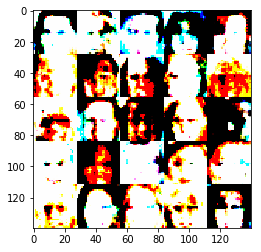

Epoch 1/1	 Discriminator Loss: 0.6902	 Generator Loss: 1.4151
Epoch 1/1	 Discriminator Loss: 1.0387	 Generator Loss: 0.9422
Epoch 1/1	 Discriminator Loss: 1.0526	 Generator Loss: 0.7499
Epoch 1/1	 Discriminator Loss: 1.0845	 Generator Loss: 0.7243
Epoch 1/1	 Discriminator Loss: 1.1498	 Generator Loss: 3.4829
Epoch 1/1	 Discriminator Loss: 0.8332	 Generator Loss: 1.0769
Epoch 1/1	 Discriminator Loss: 0.9005	 Generator Loss: 0.8993
Epoch 1/1	 Discriminator Loss: 0.9394	 Generator Loss: 1.9529
Epoch 1/1	 Discriminator Loss: 2.0215	 Generator Loss: 3.4316
Epoch 1/1	 Discriminator Loss: 0.8203	 Generator Loss: 1.1068


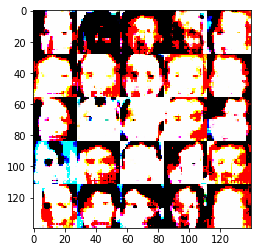

Epoch 1/1	 Discriminator Loss: 1.0397	 Generator Loss: 0.7143
Epoch 1/1	 Discriminator Loss: 1.0263	 Generator Loss: 1.2086
Epoch 1/1	 Discriminator Loss: 0.8081	 Generator Loss: 1.2462
Epoch 1/1	 Discriminator Loss: 0.5956	 Generator Loss: 2.1825
Epoch 1/1	 Discriminator Loss: 1.0752	 Generator Loss: 0.7617
Epoch 1/1	 Discriminator Loss: 0.6026	 Generator Loss: 1.6539
Epoch 1/1	 Discriminator Loss: 1.0622	 Generator Loss: 3.0788
Epoch 1/1	 Discriminator Loss: 1.1517	 Generator Loss: 0.7848
Epoch 1/1	 Discriminator Loss: 0.8762	 Generator Loss: 1.0627
Epoch 1/1	 Discriminator Loss: 0.7447	 Generator Loss: 1.3506


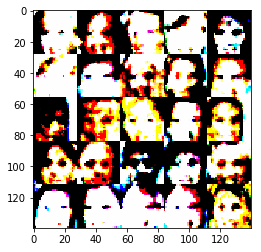

Epoch 1/1	 Discriminator Loss: 0.7545	 Generator Loss: 1.5787
Epoch 1/1	 Discriminator Loss: 1.1593	 Generator Loss: 0.6008
Epoch 1/1	 Discriminator Loss: 0.9889	 Generator Loss: 1.0350
Epoch 1/1	 Discriminator Loss: 0.8095	 Generator Loss: 1.3068
Epoch 1/1	 Discriminator Loss: 0.9919	 Generator Loss: 1.3694
Epoch 1/1	 Discriminator Loss: 1.0950	 Generator Loss: 0.7849
Epoch 1/1	 Discriminator Loss: 1.0339	 Generator Loss: 0.9328
Epoch 1/1	 Discriminator Loss: 0.5997	 Generator Loss: 1.2836
Epoch 1/1	 Discriminator Loss: 0.9562	 Generator Loss: 0.9781
Epoch 1/1	 Discriminator Loss: 1.2019	 Generator Loss: 0.7250


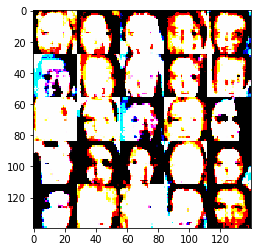

Epoch 1/1	 Discriminator Loss: 1.0655	 Generator Loss: 2.7777
Epoch 1/1	 Discriminator Loss: 0.8362	 Generator Loss: 0.9427
Epoch 1/1	 Discriminator Loss: 0.8366	 Generator Loss: 1.5675
Epoch 1/1	 Discriminator Loss: 1.2429	 Generator Loss: 0.5240
Epoch 1/1	 Discriminator Loss: 0.7918	 Generator Loss: 1.3528
Epoch 1/1	 Discriminator Loss: 0.8913	 Generator Loss: 0.8878
Epoch 1/1	 Discriminator Loss: 0.6257	 Generator Loss: 1.6671
Epoch 1/1	 Discriminator Loss: 0.6380	 Generator Loss: 1.8443
Epoch 1/1	 Discriminator Loss: 0.9639	 Generator Loss: 1.6243
Epoch 1/1	 Discriminator Loss: 1.0148	 Generator Loss: 1.1886


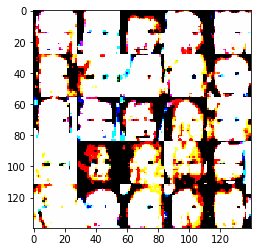

Epoch 1/1	 Discriminator Loss: 1.0531	 Generator Loss: 3.1377
Epoch 1/1	 Discriminator Loss: 0.9860	 Generator Loss: 2.8154
Epoch 1/1	 Discriminator Loss: 0.6618	 Generator Loss: 1.3239
Epoch 1/1	 Discriminator Loss: 0.8804	 Generator Loss: 2.4015
Epoch 1/1	 Discriminator Loss: 1.0883	 Generator Loss: 2.0325
Epoch 1/1	 Discriminator Loss: 1.3099	 Generator Loss: 3.4310
Epoch 1/1	 Discriminator Loss: 1.3725	 Generator Loss: 1.9823
Epoch 1/1	 Discriminator Loss: 0.8878	 Generator Loss: 1.0620
Epoch 1/1	 Discriminator Loss: 0.7436	 Generator Loss: 1.2415
Epoch 1/1	 Discriminator Loss: 1.0341	 Generator Loss: 0.8423


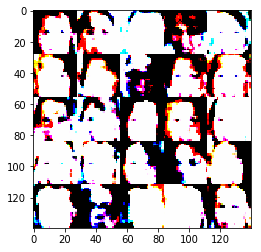

Epoch 1/1	 Discriminator Loss: 0.8193	 Generator Loss: 1.0991
Epoch 1/1	 Discriminator Loss: 0.7620	 Generator Loss: 1.0934
Epoch 1/1	 Discriminator Loss: 1.0781	 Generator Loss: 0.7210
Epoch 1/1	 Discriminator Loss: 0.7301	 Generator Loss: 1.4625
Epoch 1/1	 Discriminator Loss: 1.0531	 Generator Loss: 0.8473
Epoch 1/1	 Discriminator Loss: 0.8516	 Generator Loss: 1.4547
Epoch 1/1	 Discriminator Loss: 1.2110	 Generator Loss: 1.0642
Epoch 1/1	 Discriminator Loss: 0.8931	 Generator Loss: 1.9147
Epoch 1/1	 Discriminator Loss: 0.7185	 Generator Loss: 1.4658
Epoch 1/1	 Discriminator Loss: 1.6955	 Generator Loss: 2.9673


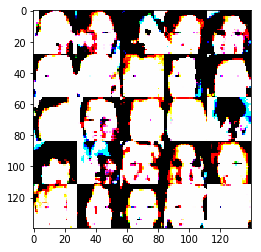

Epoch 1/1	 Discriminator Loss: 0.9452	 Generator Loss: 1.4421
Epoch 1/1	 Discriminator Loss: 0.5724	 Generator Loss: 2.8101
Epoch 1/1	 Discriminator Loss: 0.7564	 Generator Loss: 1.3352
Epoch 1/1	 Discriminator Loss: 1.7442	 Generator Loss: 2.9866
Epoch 1/1	 Discriminator Loss: 1.0710	 Generator Loss: 1.7357
Epoch 1/1	 Discriminator Loss: 0.7646	 Generator Loss: 1.2976
Epoch 1/1	 Discriminator Loss: 1.0620	 Generator Loss: 1.5376
Epoch 1/1	 Discriminator Loss: 0.7259	 Generator Loss: 1.6445
Epoch 1/1	 Discriminator Loss: 0.7530	 Generator Loss: 1.9969
Epoch 1/1	 Discriminator Loss: 1.0704	 Generator Loss: 0.7257


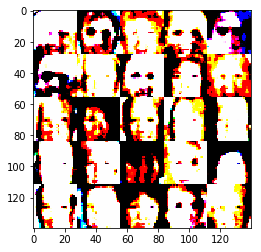

Epoch 1/1	 Discriminator Loss: 1.3174	 Generator Loss: 3.6851
Epoch 1/1	 Discriminator Loss: 0.9460	 Generator Loss: 1.0043
Epoch 1/1	 Discriminator Loss: 0.9747	 Generator Loss: 1.4556
Epoch 1/1	 Discriminator Loss: 0.8634	 Generator Loss: 2.2844
Epoch 1/1	 Discriminator Loss: 0.7820	 Generator Loss: 0.9437
Epoch 1/1	 Discriminator Loss: 0.9341	 Generator Loss: 1.6228


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.